# Calculating NDVI from Landsat 8 imagery without a GIS

The [Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index) is a simple indicator that can be used to assess whether the target, usually a remotely-sensed raster image, contains live green vegetation.  This calculation uses two bands of a remote dataset, the Red and Near-Infrared (NIR) bands.

\begin{align}
NDVI & = \frac{(NIR - Red)}{(NIR + Red)}
\end{align}

For this tutorial, we'll use the NIR and Red bands from a landsat 8 scene above part of the central valley and the Sierra Nevada in California.  We'll be using [Level 1 datasets](https://landsat.usgs.gov/landsat-processing-details), orthorectified, map-projected images containing radiometrically calibrated data. These images can be individually downloaded from a variety of sources including:

* [USGS EarthExplorer](https://earthexplorer.usgs.gov/) (Account required for download)
* [Amazon AWS](https://aws.amazon.com/public-datasets/landsat/)
* [Development Seed "Libra"](https://libra.developmentseed.org)

The specific scene we'll be using is `LC08_L1TP_042034_20170616_20170629_01_T1`, which can be downloaded from AWS at https://landsatonaws.com/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1.  Note that this is an index page that links to the scene's rasters, not the dataset itself.

More information on Landsat collections here: [https://landsat.usgs.gov/landsat-collections](https://landsat.usgs.gov/landsat-collections)

![Preview of our landsat 8 scene](http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_thumb_small.jpg)

### Bands

* Red: Band 4 (name: ``LC08_L1TP_042034_20130605_20170310_01_T1_B4.TIF``)
* Near-Infrared: Band 5 (name: ``LC08_L1TP_042034_20130605_20170310_01_T1_B5.TIF``)

Because of the longevity of the landsat mission and because different sensors on the satellite record data at different resolutions, these bands are individually stored as single-band raster files.  Some other rasters may store multiple bands in the same file.

In [2]:
%matplotlib inline

import rasterio
from matplotlib import pyplot as plt
import numpy

SCENE = 'LC08_L1TP_042034_20170616_20170629_01_T1'
AWS_URL = f'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/{SCENE}'
RED_BAND = f'{AWS_URL}/{SCENE}_B4.TIF'
NIR_BAND = f'{AWS_URL}/{SCENE}_B5.TIF'


def plot(array, label=None):
    """Plot a numpy array with a colorbar."""
    plt.imshow(array)
    plt.colorbar()
    if label is None:
        label = 'Raster {}'.format(array.shape)
    plt.title(label)
    plt.xlabel('Column #')
    plt.ylabel('Row #')

In [5]:
#open file using rasterio
with rasterio.open(RED_BAND) as raster:
    print(raster.meta) #print out metadata
    
#got this info over the web and printed the metadata to us in python data type
#these can be easily serialized into a geoJSON or whatever 

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0)}


In [7]:
import pprint

with rasterio.open(RED_BAND) as raster:
    pprint.pprint(raster.meta) #raster.profile - print meta data in a nicer format

{'count': 1,
 'crs': CRS({'init': 'epsg:32611'}),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 7951,
 'nodata': None,
 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0),
 'width': 7821}


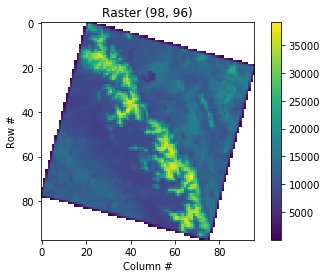

In [17]:
#the most basic way of reading in raster information is using the read method
#if you don't specify a band with rasterio it will give you a 3d thing....so it's a good idea to specify bands


with rasterio.open(RED_BAND) as raster:
    #matrix = raster.read(1) #band 1  #use this if you want all of it...but it might take awhile
    
    #instead use the overview files to get "decimation factors"
    overviews = raster.overviews(1) #band 1
    smallest_overview = overviews[-1] #get the last index of the array
    
    thumbnail = raster.read(1, out_shape=(1, raster.height // smallest_overview, raster.width // smallest_overview)) 
    
    #mask out corners
    thumbnail = thumbnail.astype(numpy.float) #convert to a float array
    thumbnail[thumbnail==0] = numpy.NaN #anywhere there is a pixel with a zero value, make it a NaN



plot(thumbnail); #it's super down sampled but gives a quick view before you download everything

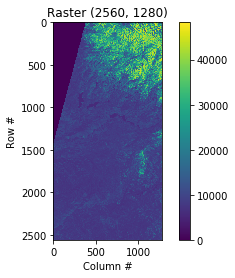

In [20]:
#use rasterio to read in a subset of a raster
import rasterio.windows 

with rasterio.open(RED_BAND) as raster:
    subset = raster.read(1,window=rasterio.windows.Window(1024,1024,1280,2560))  #this is reading from full dataset
    #define the upper left hand and lower right hand corner coordinates to define the box of your subset
    #using unpprojected pixel level indices
    
plot(subset)

In [23]:
#get transform info
from rasterio import Affine

with rasterio.open(RED_BAND) as raster:
    transform = raster.transform
    
    #30x30 meter pixels, negative means they increase downward, other numbers describe the rotation of the raster
    pprint.pprint(transform) 
    
    #use affine tranformations to adjust cell size
    pprint.pprint(transform * Affine.scale(9,9)) 

Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0)
Affine(270.0, 0.0, 204285.0,
       0.0, -270.0, 4268115.0)


In [31]:
#so far, all of what we've been reading from the server has been on the fly
#now, lets write this overview to our disk

with rasterio.open(RED_BAND) as raster:
    #raster.profile - we are copying here because we're creating a new dictionary object that links to meta information
    #this is a thing that gets around side effects of python's memory management....suuuuper complicated
    profile = raster.meta.copy() 
    
    oview_factor = src.overview(1)[1]
    pprint.pprint(oview_factor)
    pixel_values = raster.read(1, out_shape=(1, raster.height // oview_factor, raster.width // oview_factor))
    
    #use a dictionary method called update to pass key value pairs to update copy of data dictionary
    profile.update({
        'dtype': 'float32',
        'height': raster.height // oview_factor,
        'weight': raster.width // oview_factor,
        'transform': transform * Affine.scale(9,9)
    })
    
    #define new filename ('red_downsized.tif') and open up this raster dataset for writing ('w')
    with rasterio.open('red_downsized.tif','w',**profile): 
    #** profile will give the updated parameters for you into the profile
    
    #now you have to write your pixel values
        dest_raster.write(1,pixel_values)

        
    
    
    

NameError: name 'src' is not defined